In [1]:
!wget -O complaints.csv.zip "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
!unzip complaints.csv.zip


--2025-10-20 15:58:26--  https://files.consumerfinance.gov/ccdb/complaints.csv.zip
Resolving files.consumerfinance.gov (files.consumerfinance.gov)... 23.45.46.196, 23.45.46.205, 2600:1407:3c00:cc::172d:2ecd, ...
Connecting to files.consumerfinance.gov (files.consumerfinance.gov)|23.45.46.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1570119308 (1.5G) [binary/octet-stream]
Saving to: ‘complaints.csv.zip’

complaints.csv.zip  100%[===================>]   1.46G  41.4MB/s    in 28s     

2025-10-20 15:58:54 (52.8 MB/s) - ‘complaints.csv.zip’ saved [1570119308/1570119308]

Archive:  complaints.csv.zip
  inflating: complaints.csv          ^C


In [4]:
import pandas as pd

df = pd.read_csv('complaints.csv', nrows=100000, low_memory=False)
print(df.shape)
df.head(n = 10)


(100000, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,NaN,NaN,"EQUIFAX, INC.",TX,75062,NaN,NaN,Web,2025-10-14,In progress,Yes,NaN,16558024
2,2025-10-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30341,NaN,NaN,Web,2025-10-10,In progress,Yes,NaN,16507707
3,2025-10-15,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75287,NaN,NaN,Web,2025-10-15,In progress,Yes,NaN,16593757
4,2025-10-17,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NC,27127,NaN,NaN,Web,2025-10-17,In progress,Yes,NaN,16649455
5,2025-09-30,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",TX,77864,NaN,NaN,Web,2025-09-30,In progress,Yes,NaN,16261175
6,2019-12-26,Credit card or prepaid card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,94025,NaN,Consent not provided,Web,2019-12-26,Closed with explanation,Yes,NaN,3477549
7,2020-05-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,These are not my accounts.,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NV,89030,NaN,Consent provided,Web,2020-05-08,Closed with explanation,Yes,NaN,3642453
8,2025-09-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",KS,67206,NaN,NaN,Web,2025-09-24,In progress,Yes,NaN,16152255
9,2025-10-03,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Experian Information Solutions Inc.,TX,77449,NaN,NaN,Web,2025-10-03,In progress,Yes,NaN,16351107


In [5]:
!pip install -q scikit-learn xgboost imbalanced-learn matplotlib seaborn nltk wordcloud transformers datasets torch
import os, re, string, random, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set(style="whitegrid")


In [6]:
df.describe()

# Check unique values in key columns
print("\nUnique products:", df['Product'].nunique())
print("\nUnique companies:", df['Company'].nunique())



Unique products: 19

Unique companies: 1225


In [8]:

def map_category(prod):
    p = str(prod).lower()
    if "credit" in p:
        return 0  # Credit reporting, repair, or other
    elif "debt" in p:
        return 1  # Debt collection
    elif "mortgage" in p:
        return 3  # Mortgage
    elif "loan" in p and "mortgage" not in p:
        return 2  # Consumer Loan
    else:
        return None

# Apply mapping
df['label'] = df['Product'].apply(map_category)

# Compose best text column
df['text'] = df['Consumer complaint narrative'].fillna(df['Issue']).astype(str)

# Keep only rows with mapped labels and non-empty text
df = df[df['label'].notnull() & df['text'].str.strip().ne('')].copy()

# Inspect
print("Rows after filtering:", df.shape[0])
print(df['label'].value_counts())
df = df.reset_index(drop=True)


Rows after filtering: 97452
label
0.0    89811
1.0     5450
2.0     1121
3.0     1070
Name: count, dtype: int64


In [9]:
from sklearn.utils import resample

df_minority = df[df['label'] != 0]
df_majority = df[df['label'] == 0]

df_majority_down = resample(df_majority,
                            replace=False,
                            n_samples=len(df_minority)*2,
                            random_state=42)

df_balanced = pd.concat([df_majority_down, df_minority])
print(df_balanced['label'].value_counts(normalize=True))


label
0.0    0.666667
1.0    0.237752
2.0    0.048903
3.0    0.046678
Name: proportion, dtype: float64


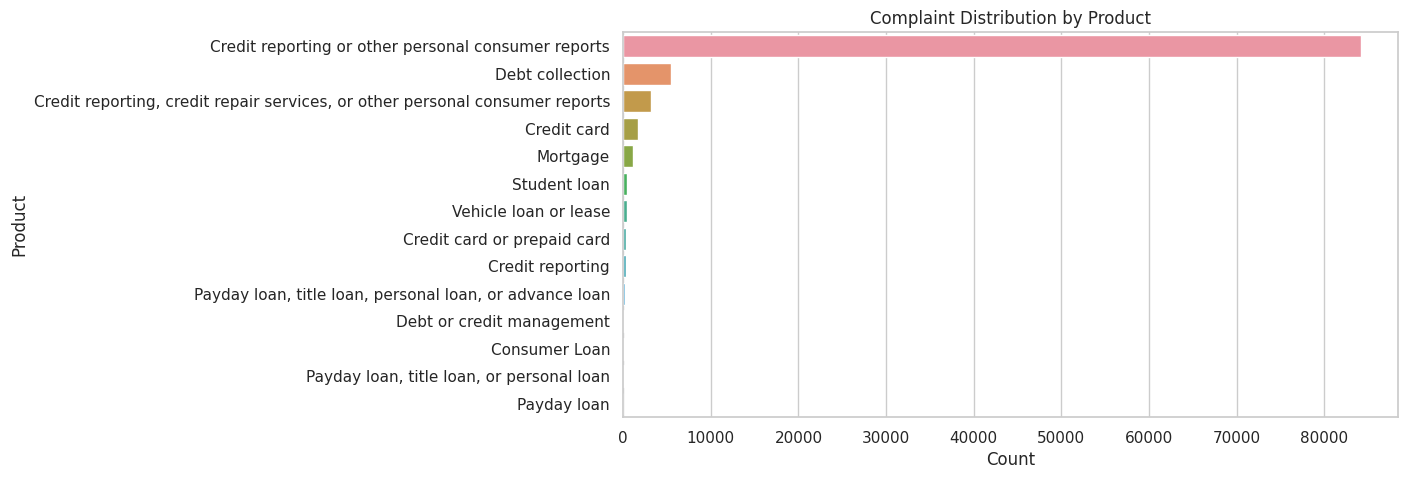

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(y='Product', data=df, order=df['Product'].value_counts().index)
plt.title('Complaint Distribution by Product')
plt.xlabel('Count')
plt.ylabel('Product')
plt.show()


In [12]:
# Word count per complaint
df_balanced['word_count'] = df_balanced['text'].apply(lambda x: len(str(x).split()))

# Character count
df_balanced['char_count'] = df_balanced['text'].apply(lambda x: len(str(x)))

# Average word length
df_balanced['avg_word_length'] = df_balanced['char_count'] / (df_balanced['word_count'] + 1)

# Summary
print(df_balanced[['word_count', 'char_count', 'avg_word_length']].describe())


         word_count    char_count  avg_word_length
count  22923.000000  22923.000000     22923.000000
mean      25.630589    152.579549         5.730266
std       85.786370    494.013969         1.029091
min        1.000000      5.000000         2.500000
25%        5.000000     33.000000         5.100000
50%        5.000000     36.000000         6.000000
75%        9.000000     51.000000         6.000000
max     2018.000000  11655.000000        13.333333


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


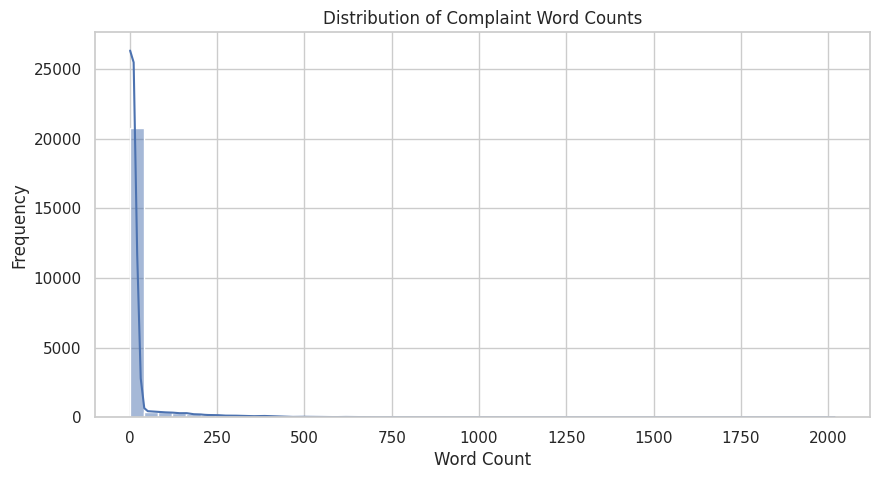

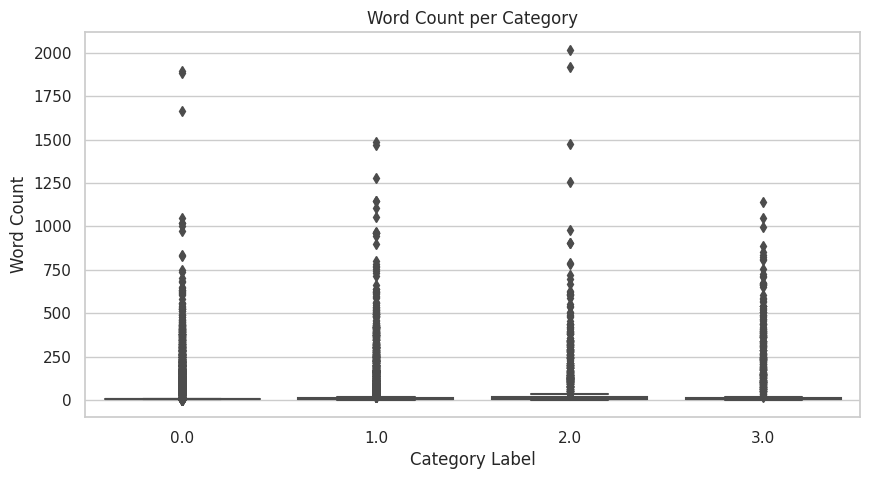

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_balanced['word_count'], bins=50, kde=True)
plt.title('Distribution of Complaint Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='label', y='word_count', data=df_balanced)
plt.title('Word Count per Category')
plt.xlabel('Category Label')
plt.ylabel('Word Count')
plt.show()


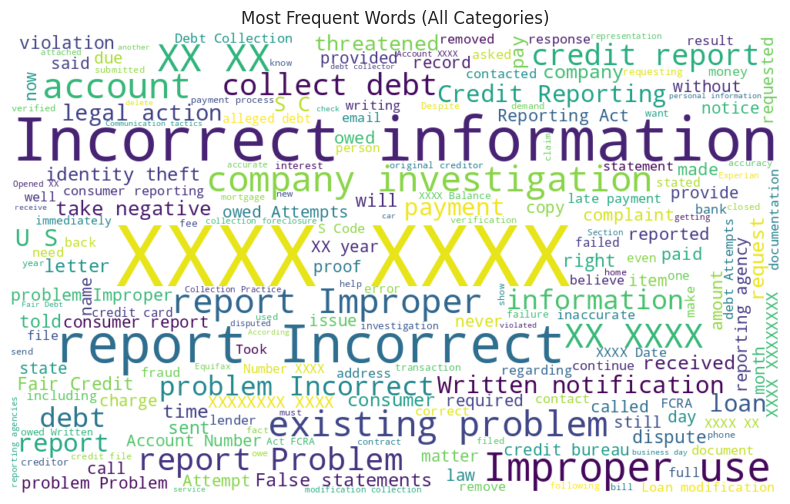

In [14]:
from wordcloud import WordCloud

# Generate for entire dataset
text_all = ' '.join(df_balanced['text'].astype(str))
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text_all)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words (All Categories)")
plt.show()


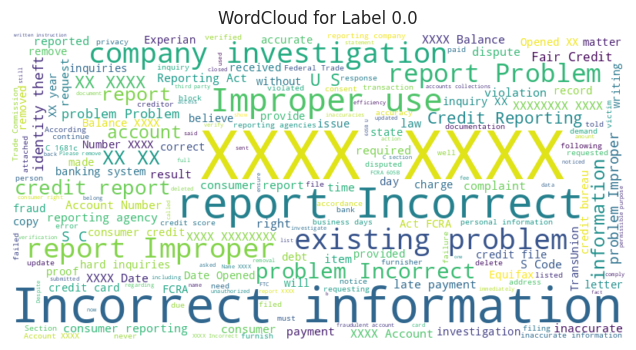

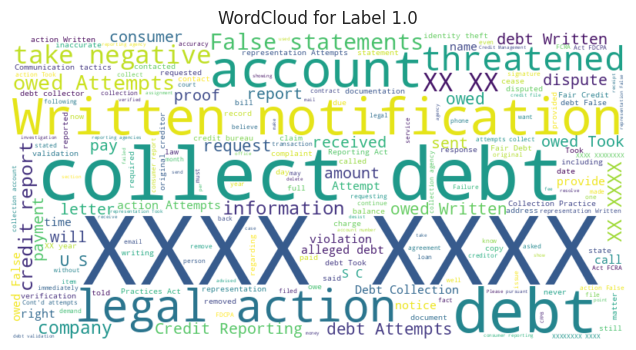

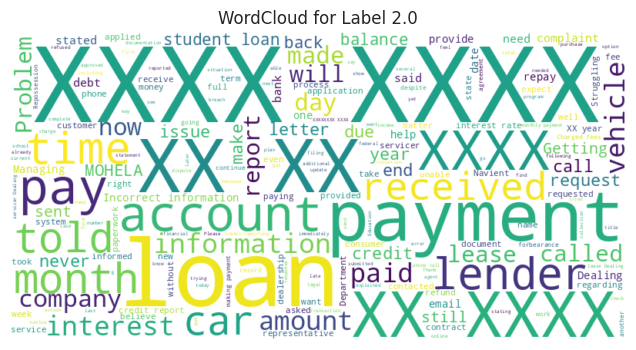

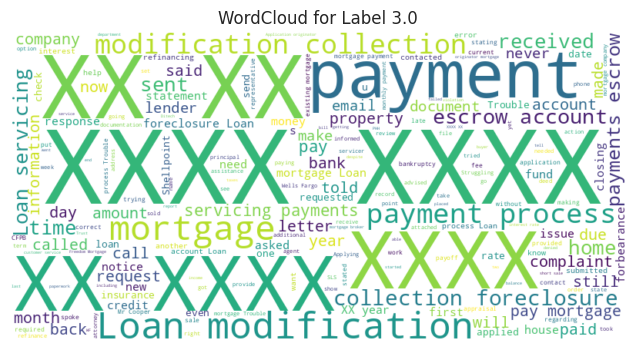

In [15]:
for label in sorted(df_balanced['label'].unique()):
    text = ' '.join(df_balanced[df_balanced['label'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Label {label}")
    plt.show()


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Example: Top bigrams and trigrams
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english')
X = vectorizer.fit_transform(df_balanced['text'])

# Sum up the occurrences of each n-gram
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Convert to DataFrame for easy viewing
top_ngrams = pd.DataFrame(words_freq[:20], columns=['ngram', 'count'])
print(top_ngrams.head(10))


                          ngram  count
0                     xxxx xxxx  16412
1                xxxx xxxx xxxx  11633
2         incorrect information   8348
3            information report   8309
4  incorrect information report   8287
5                  improper use   3214
6                    use report   3210
7           improper use report   3210
8                         xx xx   2903
9         company investigation   2533


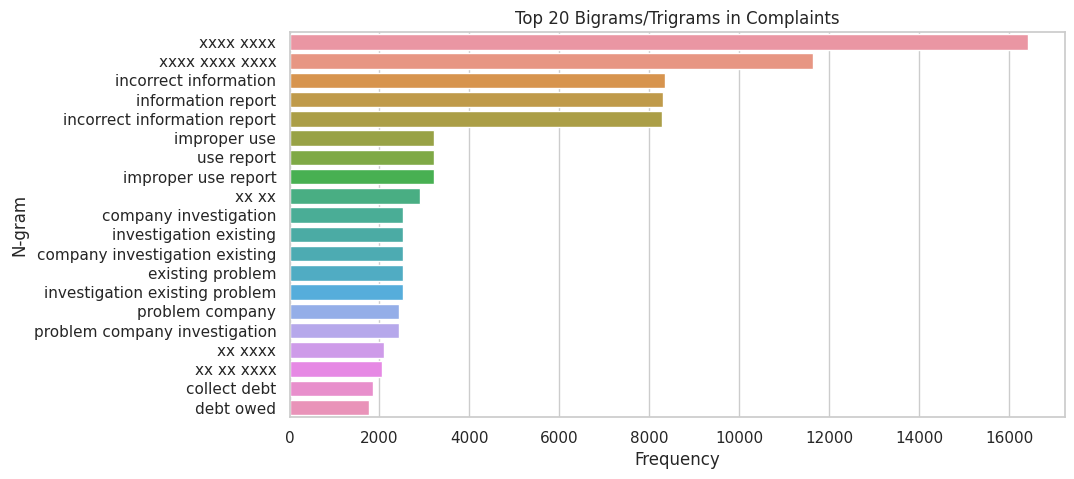

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='ngram', data=top_ngrams)
plt.title('Top 20 Bigrams/Trigrams in Complaints')
plt.xlabel('Frequency')
plt.ylabel('N-gram')
plt.show()


In [18]:
for label in sorted(df_balanced['label'].unique()):
    text_data = df_balanced[df_balanced['label'] == label]['text']
    vec = CountVectorizer(ngram_range=(2,3), stop_words='english')
    X = vec.fit_transform(text_data)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    top_ngrams = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop n-grams for Label {label}:")
    for w, c in top_ngrams:
        print(f"{w} — {c}")



Top n-grams for Label 0.0:
xxxx xxxx — 10408
xxxx xxxx xxxx — 8363
incorrect information — 8246
information report — 8221
incorrect information report — 8204
improper use — 3201
use report — 3197
improper use report — 3197
company investigation — 2509
investigation existing — 2505

Top n-grams for Label 1.0:
xxxx xxxx — 3638
xxxx xxxx xxxx — 2125
collect debt — 1838
debt owed — 1772
attempts collect — 1766
attempts collect debt — 1758
collect debt owed — 1755
written notification — 1089
notification debt — 1088
written notification debt — 1087

Top n-grams for Label 2.0:
xxxx xxxx — 1282
xxxx xxxx xxxx — 666
xx xx — 519
xx xxxx — 391
xx xx xxxx — 391
loan lease — 201
lender servicer — 163
dealing lender — 159
dealing lender servicer — 159
managing loan — 114

Top n-grams for Label 3.0:
xxxx xxxx — 1084
xx xx — 657
xx xxxx — 488
xxxx xxxx xxxx — 479
xx xx xxxx — 477
loan modification — 264
trouble payment — 208
payment process — 208
trouble payment process — 208
modification collection

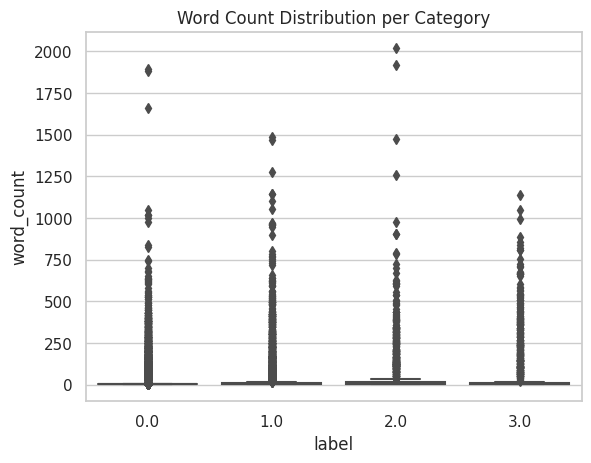

In [19]:
sns.boxplot(x='label', y='word_count', data=df_balanced)
plt.title('Word Count Distribution per Category')
plt.show()


Text Pre-Processing


In [22]:
text = text.lower()


In [25]:
import re
text = re.sub(r'[^a-zA-Z]', ' ', text)


In [26]:
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)


In [27]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]


In [28]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
tokens = [ps.stem(word) for word in tokens]


In [29]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]


In [30]:
tokens = [word for word in tokens if len(word) > 2]
text = ' '.join(tokens).strip()


Feature Engineering

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = df['text'].astype(str).values
X_bow = vectorizer.fit_transform(corpus)


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word = TfidfVectorizer()
X_tfidf = tfidf_word.fit_transform(corpus)


In [35]:
tfidf_ngram = TfidfVectorizer(ngram_range=(1,2))
X_tfidf_ngram = tfidf_ngram.fit_transform(corpus)


In [36]:
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(2,5))
X_tfidf_char = tfidf_char.fit_transform(corpus)


In [39]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X_tfidf)


In [43]:
# Make sure both come from the SAME dataframe
corpus = df_balanced['text'].astype(str).values
y = df_balanced['label'].values

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(corpus)

# Confirm shapes
print("TF-IDF shape:", X_tfidf.shape)
print("Labels shape:", y.shape)

# Now safely apply SelectKBest
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=1000).fit_transform(X_tfidf, y)

print("After feature selection:", X_new.shape)


TF-IDF shape: (22923, 5000)
Labels shape: (22923,)
After feature selection: (22923, 1000)


In [55]:
from sklearn.model_selection import train_test_split

X = X_new  # TF-IDF + feature selection
y = df_balanced['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (18338, 1000) Test shape: (4585, 1000)


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

lr = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9709923664122138
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3057
         1.0       0.98      0.96      0.97      1090
         2.0       0.95      0.76      0.84       224
         3.0       0.99      0.93      0.96       214

    accuracy                           0.97      4585
   macro avg       0.97      0.91      0.94      4585
weighted avg       0.97      0.97      0.97      4585



In [57]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


MultinomialNB Accuracy: 0.9565976008724101
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      3057
         1.0       0.94      0.96      0.95      1090
         2.0       0.78      0.76      0.77       224
         3.0       0.88      0.94      0.91       214

    accuracy                           0.96      4585
   macro avg       0.90      0.91      0.90      4585
weighted avg       0.96      0.96      0.96      4585



In [58]:
from sklearn.svm import LinearSVC

svc = LinearSVC(max_iter=5000, random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))


LinearSVC Accuracy: 0.9712104689203925
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3057
         1.0       0.98      0.95      0.97      1090
         2.0       0.93      0.77      0.84       224
         3.0       0.97      0.95      0.96       214

    accuracy                           0.97      4585
   macro avg       0.96      0.92      0.94      4585
weighted avg       0.97      0.97      0.97      4585



Deep Learnining Models


In [59]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_tensor = torch.tensor(X_train.todense(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.todense(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Model
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train_tensor.shape[1]
hidden_dim = 128
num_classes = len(set(y))

model = FFNN(input_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # for demonstration
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.1287
Epoch 2, Loss: 0.0085
Epoch 3, Loss: 0.1156
Epoch 4, Loss: 0.0967
Epoch 5, Loss: 0.0456


In [64]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


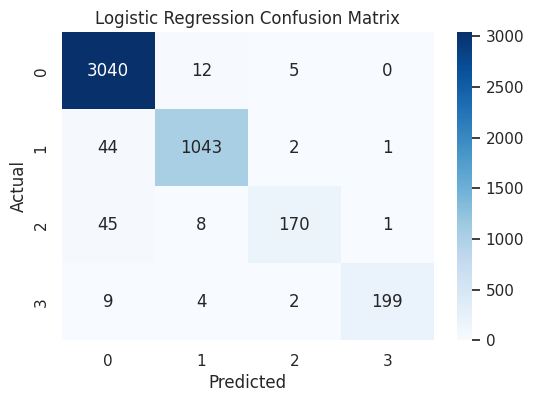

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


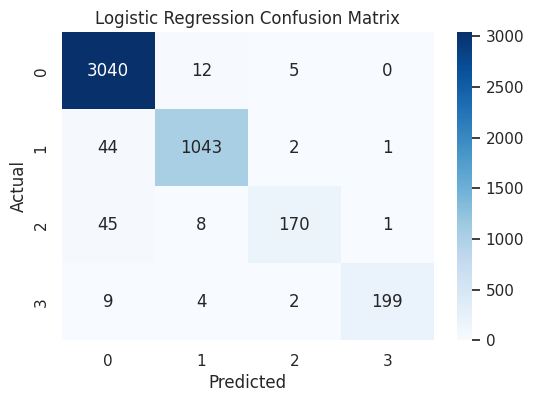

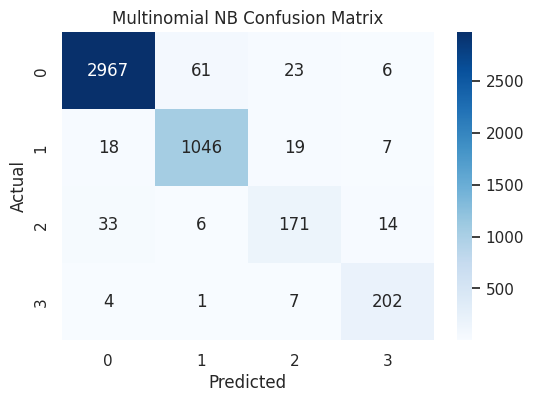

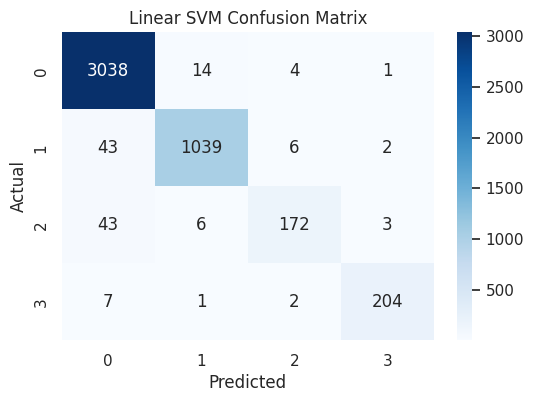

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

models = {
    "Logistic Regression": y_pred_lr,
    "Multinomial NB": y_pred_nb,
    "Linear SVM": y_pred_svc
}

metrics_summary = {}

for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds, output_dict=True)
    metrics_summary[name] = {
        "accuracy": acc,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [72]:
model.eval()  # set model to evaluation mode
all_preds = []

with torch.no_grad():  # disable gradient computation
    for xb, _ in test_loader:
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())  # collect predictions

y_pred_ffnn = np.array(all_preds)  # shape matches y_test_tensor


In [73]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(y_test_tensor, y_pred_ffnn)
report = classification_report(y_test_tensor, y_pred_ffnn)
print(f"FFNN Accuracy: {acc:.4f}")
print("Classification Report:\n", report)


FFNN Accuracy: 0.9725
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3057
           1       0.97      0.96      0.96      1090
           2       0.95      0.79      0.86       224
           3       0.99      0.95      0.97       214

    accuracy                           0.97      4585
   macro avg       0.97      0.92      0.94      4585
weighted avg       0.97      0.97      0.97      4585



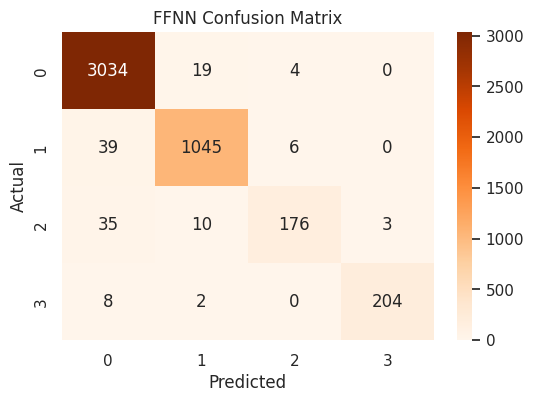

In [74]:
cm = confusion_matrix(y_test_tensor, y_pred_ffnn)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('FFNN Confusion Matrix')
plt.show()


In [75]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

models_preds = {
    "Logistic Regression": y_pred_lr,
    "Multinomial NB": y_pred_nb,
    "Linear SVM": y_pred_svc,
    "FFNN": y_pred_ffnn
}

metrics_summary = {}

for model_name, preds in models_preds.items():
    acc = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted')
    metrics_summary[model_name] = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics_summary).T
metrics_df


,accuracy,precision,recall,f1
Logistic Regression,0.970992,0.970910,0.970992,0.970249
Multinomial NB,0.956598,0.956970,0.956598,0.956683
Linear SVM,0.971210,0.970966,0.971210,0.970546
FFNN,0.972519,0.972302,0.972519,0.971965


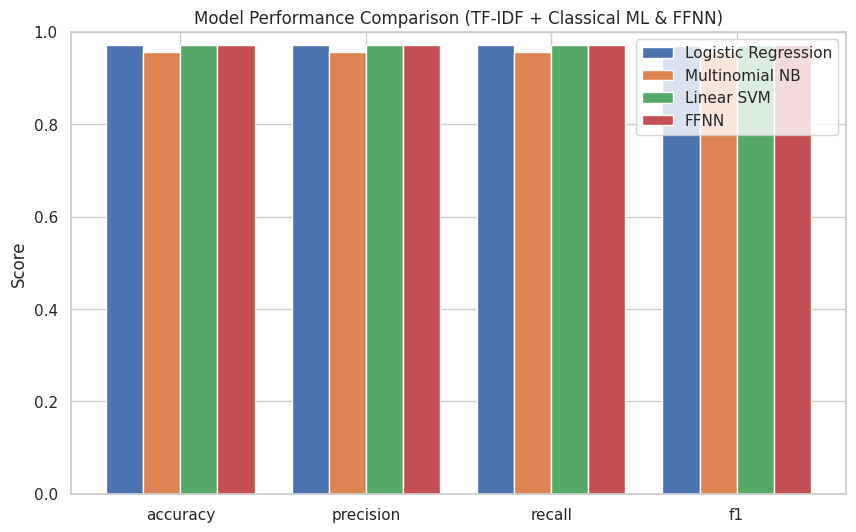

In [76]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["accuracy", "precision", "recall", "f1"]
x = np.arange(len(metrics))  # label locations
width = 0.2

plt.figure(figsize=(10,6))

for i, (model, row) in enumerate(metrics_df.iterrows()):
    plt.bar(x + i*width, row[metrics], width=width, label=model)

plt.xticks(x + width*1.5, metrics)
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Model Performance Comparison (TF-IDF + Classical ML & FFNN)")
plt.legend()
plt.show()


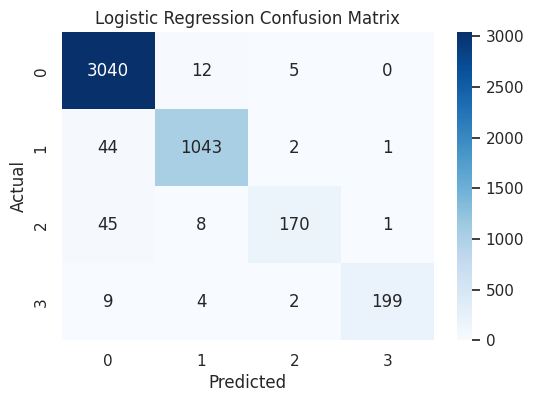

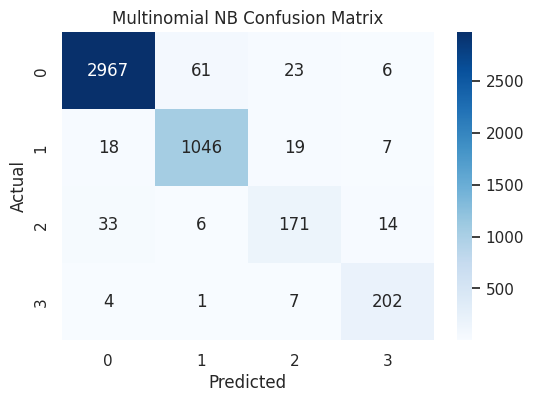

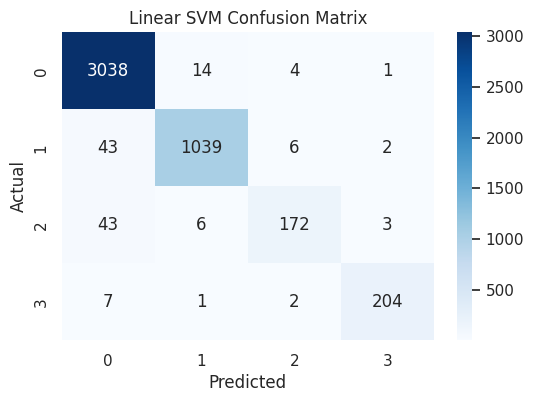

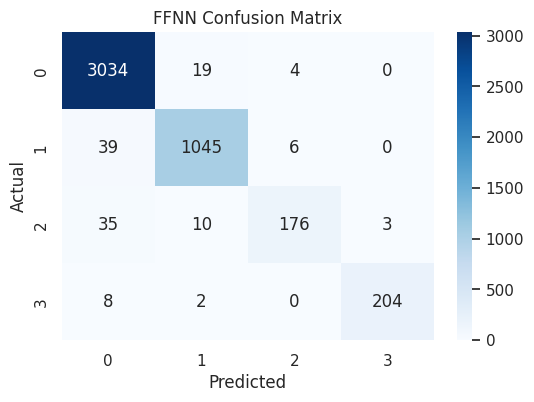

In [77]:
import seaborn as sns

for model_name, preds in models_preds.items():
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.970992,0.970910,0.970992,0.970249
Multinomial NB,0.956598,0.956970,0.956598,0.956683
Linear SVM,0.971210,0.970966,0.971210,0.970546
FFNN,0.972519,0.972302,0.972519,0.971965
